In [1]:
# Import all libraries
import os
import numpy as np
from skimage import io, transform
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
%matplotlib inline
# To be removed in the final version. Right now facing gpu memory problem
#p#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#p#os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [2]:
def show_samples(image, digit_1, digit_2, digit_3):
    plt.imshow(image, cmap = 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [38]:
import pdb
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, digit_1, digit_2, digit_3 = sample['image'], sample['digit_1'], sample['digit_2'], sample['digit_3']

        h, w = image.shape
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'digit_1': digit_1, 'digit_2': digit_2, 'digit_3': digit_3}

class Resize(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, digit_1, digit_2, digit_3 = sample['image'], sample['digit_1'], sample['digit_2'], sample['digit_3']

        h, w = image.shape
        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'digit_1': digit_1, 'digit_2': digit_2, 'digit_3': digit_3}
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, digit_1, digit_2, digit_3 = sample['image'], sample['digit_1'], sample['digit_2'], sample['digit_3']

        h, w = image.shape # changed from [:2] to nothing as the images are gray scale
        new_h, new_w = self.output_size
        
#         pdb.set_trace()
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]



        return {'image': image, 'digit_1': digit_1, 'digit_2': digit_2, 'digit_3': digit_3}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, digit_1, digit_2, digit_3 = sample['image'], sample['digit_1'], sample['digit_2'], sample['digit_3']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image[np.newaxis,:,:]
        #print(image.shape)
        #image = image.transpose((0, 2, 1))
        print(image.shape)
        return {'image': torch.from_numpy(image), 'digit_1':  torch.from_numpy(np.array(digit_1)),
                'digit_2':  torch.from_numpy(np.array(digit_2)), 'digit_3':  torch.from_numpy(np.array(digit_3))}


In [39]:
class ThreeGramDigitDataset(torch.utils.data.Dataset):
    
    def __init__(self, gt_file, dataset_root, shuffle = False, transform = None):
        
        self.dataset_root = dataset_root
        self.all_file_names = [x.split(' ')[0] for x in open(gt_file).readlines()]
        self.labels = [int(x.split(' ')[1]) for x in open(gt_file).readlines()]
        self.shuffle = shuffle
        
        if self.shuffle:
            temp = list(zip(self.all_file_names, self.labels))
            random.shuffle(temp)
            self.all_file_names, self.labels = zip(*temp)
        
        self.transform = transform
    
    
    def __len__(self):
        return len(self.all_file_names)

        
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.dataset_root, self.all_file_names[idx])
        print(img_name)
        image = io.imread(img_name)
        
        
        label_1 = int(self.labels[idx]/100) # first digit
        label_2 = int((self.labels[idx]%100)/10) # second digit
        label_3 = int((self.labels[idx]%100)%10) # third digit
        
        sample = {'image': image, 'digit_1': label_1, 'digit_2': label_2, 'digit_3': label_3}

        
        if self.transform:
            sample = self.transform(sample)
        
        return sample     
        

In [40]:
train_dataset = ThreeGramDigitDataset('3Gram_ann_test_2.txt', '../../data/lab1/imgFolders/3Gram_Digits', shuffle = False)
len(train_dataset)

3

../../data/lab1/imgFolders/3Gram_Digits/2/4_1_1_0_0.png
(0, (48, 101))
../../data/lab1/imgFolders/3Gram_Digits/2/126_1_1_0_0.png
(1, (48, 67))
../../data/lab1/imgFolders/3Gram_Digits/2/355_1_1_0_0.png
(2, (48, 100))


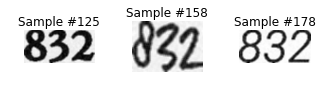

In [41]:
fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(str(sample['digit_1'])+str(sample['digit_2'])+str(sample['digit_3'])))
    ax.axis('off')
    show_samples(**sample) # way of passing a dictionary
    if i == 3:
        plt.show()
        break

../../data/lab1/imgFolders/3Gram_Digits/2/126_1_1_0_0.png
0
(256, 357)
1
(64, 128)


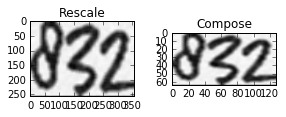

In [42]:
import pdb

scale = Rescale(256)
crop = RandomCrop(64)
composed = transforms.Compose([Rescale(99),Resize((64,128))])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[1]
#pdb.set_trace()
for i, tsfrm in enumerate([scale, composed]):
    print(tsfrm)
    print(i)
    #pdb.set_trace()
    transformed_sample = tsfrm(sample)
    print(transformed_sample['image'].shape)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_samples(**transformed_sample)

plt.show()

In [43]:
# train_dataset = ThreeGramDigitDataset('3Gram_ann_test.txt', '../../data/lab1/imgFolders/3Gram_Digits',
#                                           shuffle = False, transform=transforms.Compose([
#                                                Resize((64,128)),
#                                                ToTensor()
#                                            ]))
train_dataset = ThreeGramDigitDataset('3Gram_ann_test_2.txt', '../../data/lab1/imgFolders/3Gram_Digits',
                                          shuffle = False, transform=transforms.Compose([ToTensor()
                                           ]))

In [44]:
# Batch the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                        shuffle=False, num_workers=1)


In [45]:
# Model definition

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2_1 = nn.Linear(50, 10)
        self.fc2_2 = nn.Linear(50, 10)
        self.fc3_3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x1 = self.fc2_1(x)
        x2 = self.fc2_2(x)
        x3 = self.fc2_3(x)
        #return F.log_softmax(x1), F.log_softmax(x2), F.log_softmax(x3)
        return x1, x2, x3
    
model = Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
import pdb

plotIter = 2000
plotIterCntr = 0
numEpochs = 1
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pdb.set_trace()
    for i, data in enumerate(train_dataloader):
        pdb.set_trace()
        # get the inputs
        inputs, labels_1, labels_2, labels_3 = data['image'], data['digit_1'], data['digit_2'], data['digit_3']

        # wrap them in Variable
        inputs, labels_1, labels_2, labels_3 = Variable(inputs.cuda()), Variable(labels_1.cuda()), Variable(labels_2.cuda()), Variable(labels_3.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_1, outputs_2, outputs_3 = model(inputs)
        loss = criterion(outputs_1, labels_1)+criterion(outputs_2, labels_2)+criterion(outputs_3, labels_3)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
            
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')


> <ipython-input-46-29ad1d57638b>(13)<module>()
-> for i, data in enumerate(train_dataloader):
(Pdb) c
../../data/lab1/imgFolders/3Gram_Digits/2/4_1_1_0_0.png
(1, 48, 101)
../../data/lab1/imgFolders/3Gram_Digits/2/126_1_1_0_0.png
(1, 48, 100)
(1, 48, 67)
../../data/lab1/imgFolders/3Gram_Digits/2/355_1_1_0_0.png


RuntimeError: Traceback (most recent call last):
  File "/users/praveen.krishnan/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/users/praveen.krishnan/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 107, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/users/praveen.krishnan/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 107, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/users/praveen.krishnan/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 90, in default_collate
    storage = batch[0].storage()._new_shared(numel)
  File "/users/praveen.krishnan/.local/lib/python2.7/site-packages/torch/storage.py", line 113, in _new_shared
    return cls._new_using_fd(size)
RuntimeError: $ Torch: unable to mmap memory: you tried to mmap 0GB. at /b/wheel/pytorch-src/torch/lib/TH/THAllocator.c:317
